# Further Analysis: Advanced Risk Modeling for Tree Prioritization

## Building on Base Analysis

This notebook extends the base analysis with:
1. **Temporal Patterns**: Seasonal and yearly trends in failures
2. **Geographic Analysis**: Quarter section and district-level risk aggregation
3. **Advanced Risk Scoring**: Multi-factor weighted priority scores
4. **Impact Analysis**: Property type, infrastructure proximity, failure severity
5. **Pruning Cycle Analysis**: Effectiveness of current pruning schedules
6. **Age Estimation**: DBH-based age correlation with failures
7. **Cost-Benefit Analysis**: Resource allocation optimization

## Project Goals Alignment

Per the project proposal:
- Develop a "Weighted Priority Score" algorithm
- Aggregate scores into Quarter Section heat maps
- Compare Current Methods vs. Proposed Methods
- Support budget justification with data-driven insights

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('seaborn')
sns.set_palette("husl")

# Load the full dataset (same as base_analysis)
print("=== LOADING FULL DATASET ===")
service_df = pd.read_csv('../../data/10 year service requests.csv')
inventory_df = pd.read_csv('../../data/Inventory 1-15-26.csv', low_memory=False)

print(f"Service requests: {len(service_df):,}")
print(f"Inventory trees: {len(inventory_df):,}")

# Convert date columns
service_df['EnterDt'] = pd.to_datetime(service_df['EnterDt'], errors='coerce')
service_df['ResolvDt'] = pd.to_datetime(service_df['ResolvDt'], errors='coerce')
inventory_df['Inventory Date'] = pd.to_datetime(inventory_df['Inventory Date'], errors='coerce')

# Calculate resolution time
service_df['Resolution_Time_Hours'] = (service_df['ResolvDt'] - service_df['EnterDt']).dt.total_seconds() / 3600

# Categorize failures (same as base_analysis)
def categorize_failure(service_text):
    if pd.isna(service_text):
        return 'Other'
    service_lower = str(service_text).lower()
    if 'branch' in service_lower or 'limb' in service_lower:
        return 'Branch Failure'
    elif 'tree' in service_lower and ('down' in service_lower or 'fallen' in service_lower):
        return 'Tree Failure'
    elif 'structural' in service_lower or 'split' in service_lower or 'crack' in service_lower:
        return 'Structural Issue'
    elif 'prune' in service_lower or 'trim' in service_lower:
        return 'Pruning Request'
    else:
        return 'Other'

service_df['Failure_Category'] = service_df['Service'].apply(categorize_failure)

# Simplify species names (same as base_analysis)
def simplify_species(species):
    if pd.isna(species):
        return 'Unknown'
    species_str = str(species).upper()
    # Extract first part before comma or parentheses
    if ',' in species_str:
        return species_str.split(',')[0].strip()
    elif '(' in species_str:
        return species_str.split('(')[0].strip()
    else:
        return species_str.split()[0] if species_str.split() else 'Unknown'

inventory_df['Species_Simple'] = inventory_df['Species'].apply(simplify_species)

print("\nData loaded and preprocessed successfully!")

=== LOADING FULL DATASET ===
Service requests: 64,614
Inventory trees: 189,382

Data loaded and preprocessed successfully!


## 1. Temporal Analysis: Seasonal and Yearly Patterns

Understanding when failures occur helps with:
- Resource planning (staffing during high-risk seasons)
- Identifying weather-related patterns
- Trend analysis for budget justification

=== YEARLY FAILURE TRENDS ===

Total requests by year:
Year
2016    4156
2017    4708
2018    4393
2019    6305
2020    6645
2021    8284
2022    5702
2023    9829
2024    7231
2025    7360
2026       1
Name: Total_Requests, dtype: int64

Seasonal distribution:
Season
Fall      13175
Spring    12461
Summer    34106
Winter     4872
Name: Total_Requests, dtype: int64


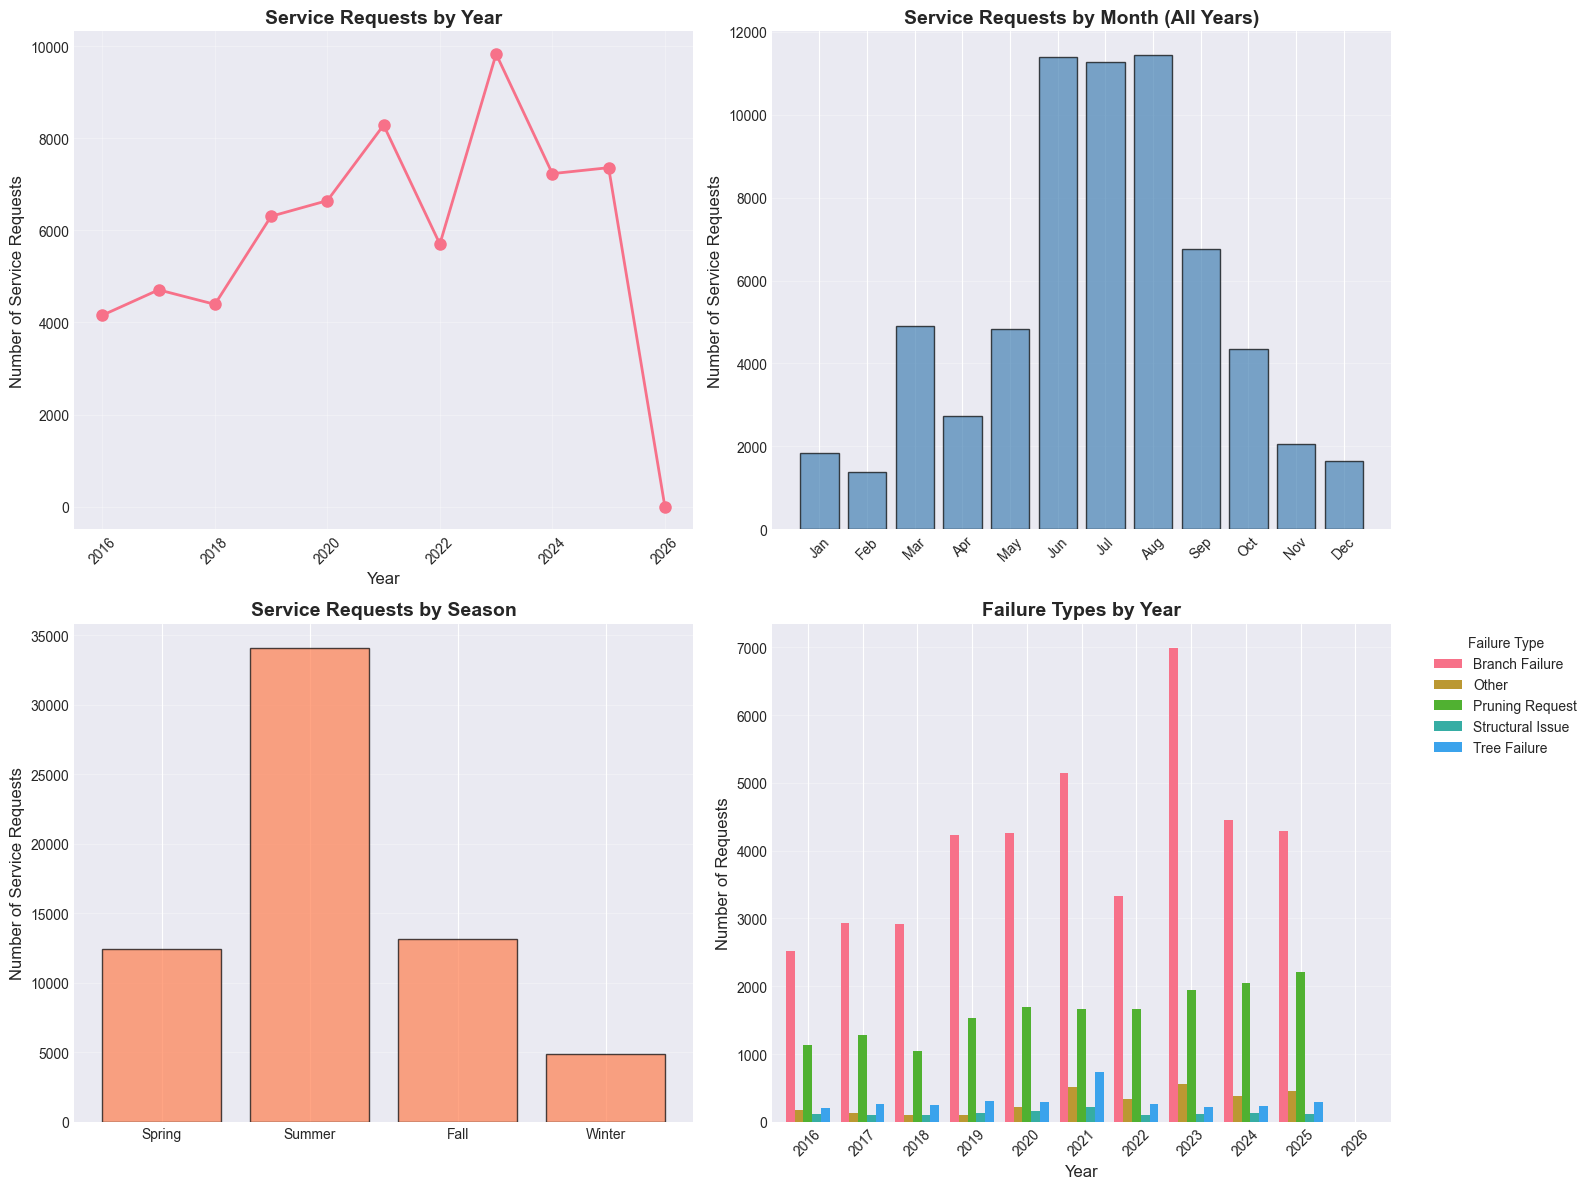


=== KEY TEMPORAL INSIGHTS ===
Peak failure month: Aug (11,441 requests)
Peak failure season: Summer (34,106 requests)
Average requests per month: 5384
Year-over-year trend: Decreasing


In [3]:
# Extract temporal features
service_df['Year'] = service_df['EnterDt'].dt.year
service_df['Month'] = service_df['EnterDt'].dt.month
service_df['DayOfYear'] = service_df['EnterDt'].dt.dayofyear
service_df['Season'] = service_df['EnterDt'].dt.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# Yearly trends
print("=== YEARLY FAILURE TRENDS ===")
yearly_failures = service_df.groupby('Year').agg({
    'Rec#': 'count',
    'Failure_Category': lambda x: x.value_counts().to_dict()
}).rename(columns={'Rec#': 'Total_Requests'})

print(f"\nTotal requests by year:")
print(yearly_failures['Total_Requests'])

# Monthly/Seasonal patterns
monthly_failures = service_df.groupby('Month').agg({
    'Rec#': 'count',
    'Failure_Category': lambda x: x.value_counts().to_dict()
}).rename(columns={'Rec#': 'Total_Requests'})

seasonal_failures = service_df.groupby('Season').agg({
    'Rec#': 'count',
    'Failure_Category': lambda x: x.value_counts().to_dict()
}).rename(columns={'Rec#': 'Total_Requests'})

print(f"\nSeasonal distribution:")
print(seasonal_failures['Total_Requests'])

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Yearly trend
yearly_counts = service_df.groupby('Year')['Rec#'].count()
axes[0, 0].plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Year', fontsize=12)
axes[0, 0].set_ylabel('Number of Service Requests', fontsize=12)
axes[0, 0].set_title('Service Requests by Year', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Monthly pattern
monthly_counts = service_df.groupby('Month')['Rec#'].count()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 1].bar(range(1, 13), [monthly_counts.get(i, 0) for i in range(1, 13)], 
               color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_names, rotation=45)
axes[0, 1].set_ylabel('Number of Service Requests', fontsize=12)
axes[0, 1].set_title('Service Requests by Month (All Years)', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Seasonal pattern
seasonal_counts = service_df.groupby('Season')['Rec#'].count()
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
axes[1, 0].bar(range(len(season_order)), [seasonal_counts.get(s, 0) for s in season_order],
               color='coral', edgecolor='black', alpha=0.7)
axes[1, 0].set_xticks(range(len(season_order)))
axes[1, 0].set_xticklabels(season_order)
axes[1, 0].set_ylabel('Number of Service Requests', fontsize=12)
axes[1, 0].set_title('Service Requests by Season', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Failure types by year
failure_by_year = pd.crosstab(service_df['Year'], service_df['Failure_Category'])
failure_by_year.plot(kind='bar', ax=axes[1, 1], width=0.8)
axes[1, 1].set_xlabel('Year', fontsize=12)
axes[1, 1].set_ylabel('Number of Requests', fontsize=12)
axes[1, 1].set_title('Failure Types by Year', fontsize=14, fontweight='bold')
axes[1, 1].legend(title='Failure Type', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
print("\n=== KEY TEMPORAL INSIGHTS ===")
peak_month = monthly_counts.idxmax()
peak_season = seasonal_counts.idxmax()
print(f"Peak failure month: {month_names[peak_month-1]} ({monthly_counts[peak_month]:,} requests)")
print(f"Peak failure season: {peak_season} ({seasonal_counts[peak_season]:,} requests)")
print(f"Average requests per month: {monthly_counts.mean():.0f}")
print(f"Year-over-year trend: {'Increasing' if yearly_counts.iloc[-1] > yearly_counts.iloc[0] else 'Decreasing'}")

## 2. Geographic Analysis: Quarter Section and District Risk Aggregation

Per the project proposal, we need to aggregate individual tree scores into Quarter Section heat maps for operational planning.

=== MATCHING SERVICE REQUESTS TO INVENTORY ===
Matched 14,147 service requests to 7,940 unique trees

=== QUARTER SECTION RISK ANALYSIS ===

Top 20 Highest Risk Quarter Sections:
                 Total_Trees  Total_Failures  Failure_Rate  Risk_Score
Quarter Section                                                       
578                      264             119     45.075758   43.021803
122                      317             110     34.700315   40.538677
539                      678             151     22.271386   38.386284
138                      141              44     31.205674   38.325943
540                      629             178     28.298887   36.757081
548                      671             174     25.931446   35.206049
137                      229              54     23.580786   34.609356
148                      313              62     19.808307   34.394007
541                      642             127     19.781931   34.125835
457                      412            

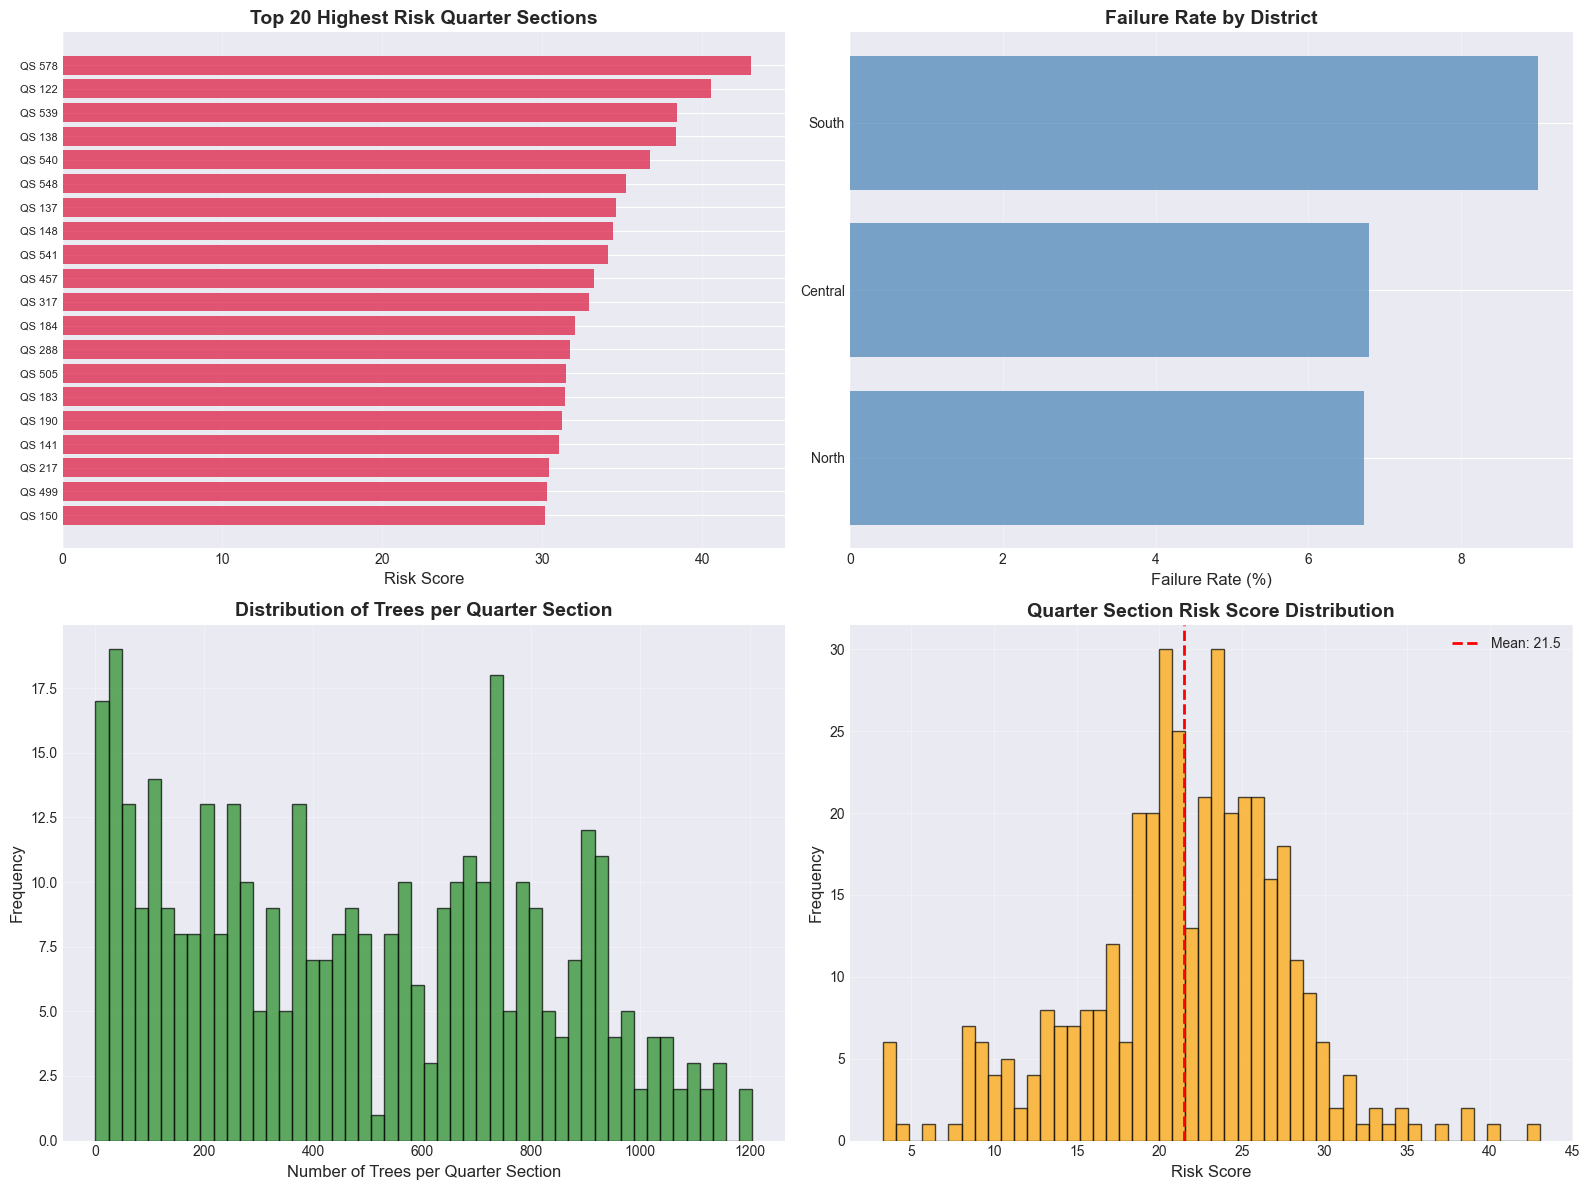

In [4]:
# Match service requests to inventory (same approach as base_analysis)
print("=== MATCHING SERVICE REQUESTS TO INVENTORY ===")

# Prepare matching keys
service_df['Q'] = service_df['Q'].astype(str).str.replace('.0', '', regex=False)
inventory_df['Quarter Section'] = inventory_df['Quarter Section'].astype(str).str.replace('.0', '', regex=False)

# Filter to single-tree addresses for accurate matching
address_tree_counts = inventory_df.groupby(['Quarter Section', 'Address']).size().reset_index(name='Tree_Count')
single_tree_addresses = address_tree_counts[address_tree_counts['Tree_Count'] == 1]
inventory_single_tree = inventory_df.merge(
    single_tree_addresses[['Quarter Section', 'Address']],
    on=['Quarter Section', 'Address'],
    how='inner'
)

# Merge service requests with inventory
merged = pd.merge(
    service_df,
    inventory_single_tree,
    left_on=['Q', 'A'],
    right_on=['Quarter Section', 'Address'],
    how='inner',
    suffixes=('_service', '_inventory')
)

print(f"Matched {len(merged):,} service requests to {merged['Site ID'].nunique():,} unique trees")

# Calculate failure counts per tree
tree_failures = merged.groupby('Site ID').agg({
    'Rec#': 'count',
    'Failure_Category': lambda x: x.value_counts().to_dict()
}).rename(columns={'Rec#': 'Failure_Count'})

# Merge back to full inventory
inventory_with_failures = inventory_df.merge(
    tree_failures.reset_index(),
    on='Site ID',
    how='left'
)
inventory_with_failures['Failure_Count'] = inventory_with_failures['Failure_Count'].fillna(0).astype(int)

# Quarter Section Analysis
print("\n=== QUARTER SECTION RISK ANALYSIS ===")
qs_analysis = inventory_with_failures.groupby('Quarter Section').agg({
    'Site ID': 'count',
    'Failure_Count': 'sum',
    'DBH': 'mean',
    'Condition': lambda x: (x == 'Poor').sum()
}).rename(columns={
    'Site ID': 'Total_Trees',
    'Failure_Count': 'Total_Failures',
    'DBH': 'Avg_DBH',
    'Condition': 'Poor_Condition_Count'
})

qs_analysis['Failure_Rate'] = (qs_analysis['Total_Failures'] / qs_analysis['Total_Trees'] * 100).fillna(0)
qs_analysis['Risk_Score'] = (
    qs_analysis['Failure_Rate'] * 0.4 +
    (qs_analysis['Poor_Condition_Count'] / qs_analysis['Total_Trees'] * 100) * 0.3 +
    (qs_analysis['Avg_DBH'] / qs_analysis['Avg_DBH'].max() * 100) * 0.3
)

qs_analysis = qs_analysis.sort_values('Risk_Score', ascending=False)

print(f"\nTop 20 Highest Risk Quarter Sections:")
print(qs_analysis.head(20)[['Total_Trees', 'Total_Failures', 'Failure_Rate', 'Risk_Score']])

# District Analysis
print("\n=== DISTRICT RISK ANALYSIS ===")
district_analysis = inventory_with_failures.groupby('District').agg({
    'Site ID': 'count',
    'Failure_Count': 'sum',
    'DBH': 'mean',
    'Condition': lambda x: (x == 'Poor').sum()
}).rename(columns={
    'Site ID': 'Total_Trees',
    'Failure_Count': 'Total_Failures',
    'DBH': 'Avg_DBH',
    'Condition': 'Poor_Condition_Count'
})

district_analysis['Failure_Rate'] = (district_analysis['Total_Failures'] / district_analysis['Total_Trees'] * 100).fillna(0)
district_analysis = district_analysis.sort_values('Failure_Rate', ascending=False)

print(f"\nDistrict Risk Rankings:")
print(district_analysis[['Total_Trees', 'Total_Failures', 'Failure_Rate']])

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top Quarter Sections by Risk
top_qs = qs_analysis.head(20)
axes[0, 0].barh(range(len(top_qs)), top_qs['Risk_Score'].values, color='crimson', alpha=0.7)
axes[0, 0].set_yticks(range(len(top_qs)))
axes[0, 0].set_yticklabels([f"QS {idx}" for idx in top_qs.index[:20]], fontsize=8)
axes[0, 0].set_xlabel('Risk Score', fontsize=12)
axes[0, 0].set_title('Top 20 Highest Risk Quarter Sections', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].invert_yaxis()

# District Failure Rates
district_analysis_sorted = district_analysis.sort_values('Failure_Rate', ascending=True)
axes[0, 1].barh(range(len(district_analysis_sorted)), district_analysis_sorted['Failure_Rate'].values,
                color='steelblue', alpha=0.7)
axes[0, 1].set_yticks(range(len(district_analysis_sorted)))
axes[0, 1].set_yticklabels(district_analysis_sorted.index, fontsize=10)
axes[0, 1].set_xlabel('Failure Rate (%)', fontsize=12)
axes[0, 1].set_title('Failure Rate by District', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# Quarter Section Tree Count Distribution
axes[1, 0].hist(qs_analysis['Total_Trees'], bins=50, color='forestgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Number of Trees per Quarter Section', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Distribution of Trees per Quarter Section', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Risk Score Distribution
axes[1, 1].hist(qs_analysis['Risk_Score'], bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(qs_analysis['Risk_Score'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {qs_analysis["Risk_Score"].mean():.1f}')
axes[1, 1].set_xlabel('Risk Score', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Quarter Section Risk Score Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Advanced Risk Scoring: Multi-Factor Weighted Priority Score

Per the project proposal, we need a weighted priority score incorporating:
- Species risk
- Size (DBH)
- Age (estimated from DBH)
- Historical failure data
- Condition
- Property type (infrastructure impact)
- Pruning cycle status

=== CREATING ADVANCED RISK SCORING ===

Risk Score Statistics:
count    189382.000000
mean         26.218762
std          11.301118
min           0.000000
25%          17.171356
50%          25.776222
75%          32.956195
max         100.000000
Name: Weighted_Priority_Score, dtype: float64

Risk Category Distribution:
Risk_Category
Low         126348
Medium       58931
High          2478
Critical      1616
Name: count, dtype: int64

Top 20 Highest Risk Trees:
        Site ID     Species_Simple   DBH Condition  Failure_History Property Type  Weighted_Priority_Score Risk_Category
171922   123477            HICKORY  15.0      Fair              5.0   Residential               100.000000      Critical
33797    135280  AMERICAN SYCAMORE  28.0      Poor              3.0   Residential                98.105819      Critical
36968      8106                ASH  40.0      Poor              4.0   Residential                97.705336      Critical
95226    162294              MAPLE  27.0      Poor

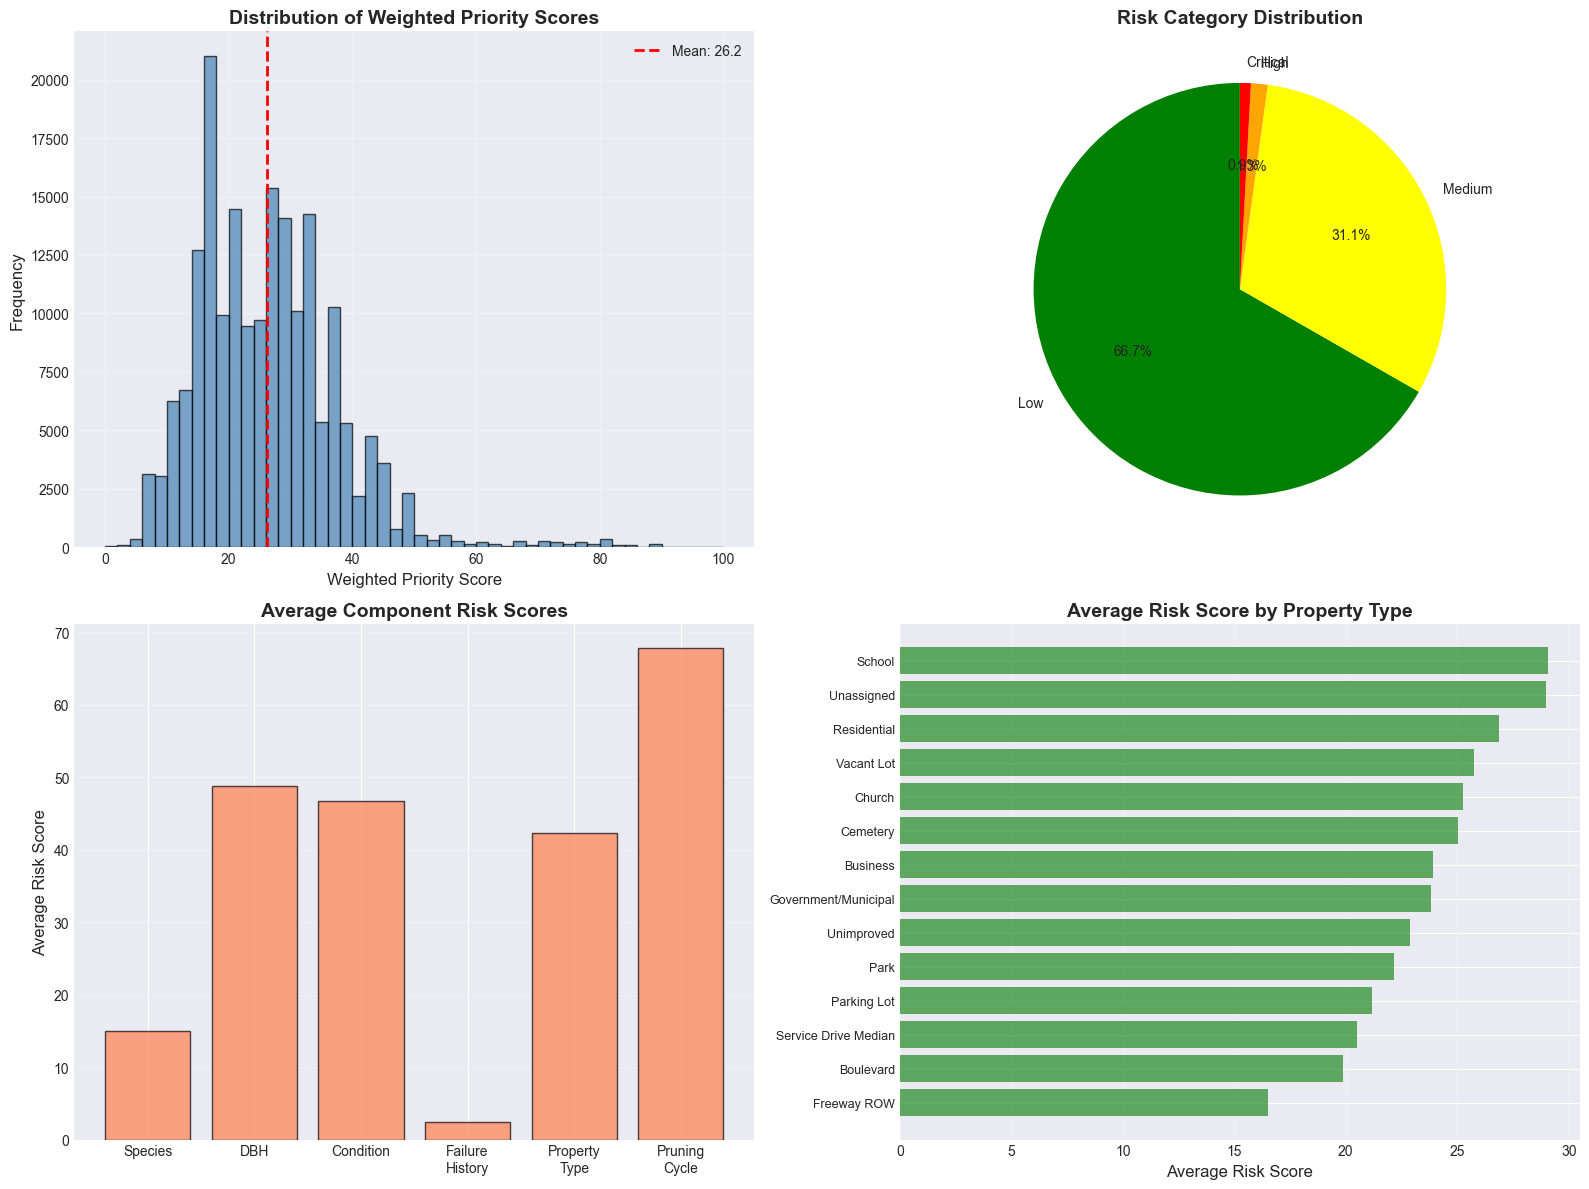

In [5]:
# Calculate species failure rates (from matched data)
if len(merged) > 0:
    species_failure_counts = merged.groupby('Species_Simple')['Rec#'].nunique()
    species_total_counts = inventory_df['Species_Simple'].value_counts()
    species_failure_rates = pd.DataFrame({
        'Total_Trees': species_total_counts,
        'Unique_Service_Requests': species_failure_counts
    }).fillna(0)
    species_failure_rates['Failure_Rate'] = (
        species_failure_rates['Unique_Service_Requests'] / 
        species_failure_rates['Total_Trees'] * 100
    )
    species_failure_rates = species_failure_rates[species_failure_rates['Total_Trees'] >= 10]
else:
    species_failure_rates = pd.DataFrame()

# Create comprehensive risk scoring dataset
print("=== CREATING ADVANCED RISK SCORING ===")
risk_df = inventory_df.copy()

# 1. Species Risk Score (0-100)
if len(species_failure_rates) > 0:
    species_risk_map = species_failure_rates['Failure_Rate'].to_dict()
    risk_df['Species_Risk'] = risk_df['Species_Simple'].map(species_risk_map).fillna(50)  # Default medium risk
    # Normalize to 0-100
    risk_df['Species_Risk'] = ((risk_df['Species_Risk'] - risk_df['Species_Risk'].min()) / 
                               (risk_df['Species_Risk'].max() - risk_df['Species_Risk'].min()) * 100).fillna(50)
else:
    risk_df['Species_Risk'] = 50  # Default if no data

# 2. Size Risk Score (DBH) - Larger trees = higher risk
risk_df['DBH_Risk'] = pd.cut(
    risk_df['DBH'],
    bins=[0, 6, 12, 18, 24, 100],
    labels=[20, 40, 60, 80, 100]
).astype(float).fillna(50)

# 3. Condition Risk Score
condition_risk_map = {'Excellent': 20, 'Good': 40, 'Fair': 60, 'Poor': 90, 'Dead': 100}
risk_df['Condition_Risk'] = risk_df['Condition'].map(condition_risk_map).fillna(50)

# 4. Historical Failure Risk
if len(merged) > 0:
    tree_failure_counts = merged.groupby('Site ID')['Rec#'].count()
    risk_df['Failure_History'] = risk_df['Site ID'].map(tree_failure_counts).fillna(0)
    # Scale: 0 failures = 0, 1 failure = 30, 2+ failures = 100
    risk_df['Failure_Risk'] = risk_df['Failure_History'].apply(
        lambda x: 0 if x == 0 else 30 if x == 1 else 100
    )
else:
    risk_df['Failure_History'] = 0
    risk_df['Failure_Risk'] = 0

# 5. Property Type Risk (infrastructure impact)
# Higher risk for trees near buildings, utilities, high-traffic areas
property_risk_map = {
    'Residential': 40,
    'Commercial': 70,
    'Industrial': 60,
    'Park': 30,
    'Street': 80,  # High traffic
    'School': 90,  # High safety concern
    'Hospital': 100,  # Critical infrastructure
}
risk_df['Property_Risk'] = risk_df['Property Type'].map(property_risk_map).fillna(50)

# 6. Pruning Cycle Risk (time since last prune)
risk_df['Inventory Date'] = pd.to_datetime(risk_df['Inventory Date'], errors='coerce')
current_date = pd.Timestamp.now()
risk_df['Years_Since_Inventory'] = (current_date - risk_df['Inventory Date']).dt.days / 365.25
risk_df['Years_Since_Inventory'] = risk_df['Years_Since_Inventory'].fillna(10)  # Assume old if missing

# Pruning cycle risk: longer since inventory = higher risk
risk_df['Pruning_Cycle_Risk'] = pd.cut(
    risk_df['Years_Since_Inventory'],
    bins=[0, 3, 6, 10, 20, 100],
    labels=[20, 40, 60, 80, 100]
).astype(float).fillna(60)

# 7. Age Estimation (from DBH)
# Rough estimate: DBH in inches ≈ age in years for many species (very rough)
# Adjust for species growth rates if available
risk_df['Estimated_Age'] = risk_df['DBH'] * 1.2  # Rough multiplier
risk_df['Age_Risk'] = pd.cut(
    risk_df['Estimated_Age'],
    bins=[0, 10, 20, 40, 60, 200],
    labels=[20, 30, 50, 70, 90]
).astype(float).fillna(50)

# COMPOSITE WEIGHTED RISK SCORE
# Weights based on project proposal priorities
risk_df['Weighted_Priority_Score'] = (
    risk_df['Species_Risk'] * 0.20 +      # Species is important predictor
    risk_df['DBH_Risk'] * 0.15 +           # Size matters
    risk_df['Condition_Risk'] * 0.20 +    # Condition is critical
    risk_df['Failure_Risk'] * 0.25 +      # Historical failures = highest weight
    risk_df['Property_Risk'] * 0.10 +     # Infrastructure impact
    risk_df['Pruning_Cycle_Risk'] * 0.10  # Maintenance status
)

# Normalize to 0-100 scale
risk_df['Weighted_Priority_Score'] = (
    (risk_df['Weighted_Priority_Score'] - risk_df['Weighted_Priority_Score'].min()) /
    (risk_df['Weighted_Priority_Score'].max() - risk_df['Weighted_Priority_Score'].min()) * 100
)

# Risk Categories
risk_df['Risk_Category'] = pd.cut(
    risk_df['Weighted_Priority_Score'],
    bins=[0, 30, 50, 70, 100],
    labels=['Low', 'Medium', 'High', 'Critical']
)

print(f"\nRisk Score Statistics:")
print(risk_df['Weighted_Priority_Score'].describe())

print(f"\nRisk Category Distribution:")
print(risk_df['Risk_Category'].value_counts())

# Top risk trees
print(f"\nTop 20 Highest Risk Trees:")
top_risk = risk_df.nlargest(20, 'Weighted_Priority_Score')[
    ['Site ID', 'Species_Simple', 'DBH', 'Condition', 'Failure_History', 
     'Property Type', 'Weighted_Priority_Score', 'Risk_Category']
]
print(top_risk.to_string())

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Risk Score Distribution
axes[0, 0].hist(risk_df['Weighted_Priority_Score'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(risk_df['Weighted_Priority_Score'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {risk_df["Weighted_Priority_Score"].mean():.1f}')
axes[0, 0].set_xlabel('Weighted Priority Score', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Weighted Priority Scores', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Risk Category Pie Chart
risk_cat_counts = risk_df['Risk_Category'].value_counts()
axes[0, 1].pie(risk_cat_counts.values, labels=risk_cat_counts.index, autopct='%1.1f%%',
               colors=['green', 'yellow', 'orange', 'red'], startangle=90)
axes[0, 1].set_title('Risk Category Distribution', fontsize=14, fontweight='bold')

# Component Risk Scores Comparison
component_risks = ['Species_Risk', 'DBH_Risk', 'Condition_Risk', 'Failure_Risk', 
                   'Property_Risk', 'Pruning_Cycle_Risk']
component_means = [risk_df[col].mean() for col in component_risks]
component_labels = ['Species', 'DBH', 'Condition', 'Failure\nHistory', 
                    'Property\nType', 'Pruning\nCycle']
axes[1, 0].bar(range(len(component_means)), component_means, color='coral', alpha=0.7, edgecolor='black')
axes[1, 0].set_xticks(range(len(component_labels)))
axes[1, 0].set_xticklabels(component_labels, fontsize=10)
axes[1, 0].set_ylabel('Average Risk Score', fontsize=12)
axes[1, 0].set_title('Average Component Risk Scores', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Risk Score by Property Type
property_risk_avg = risk_df.groupby('Property Type')['Weighted_Priority_Score'].mean().sort_values(ascending=True)
axes[1, 1].barh(range(len(property_risk_avg)), property_risk_avg.values, color='forestgreen', alpha=0.7)
axes[1, 1].set_yticks(range(len(property_risk_avg)))
axes[1, 1].set_yticklabels(property_risk_avg.index, fontsize=9)
axes[1, 1].set_xlabel('Average Risk Score', fontsize=12)
axes[1, 1].set_title('Average Risk Score by Property Type', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Failure Severity and Impact Analysis

Understanding failure severity helps prioritize resources toward high-impact failures.

=== FAILURE SEVERITY ANALYSIS ===

Failure Category Analysis:
                  Count  Avg_Severity  Avg_Resolution_Days  \
Failure_Category                                             
Branch Failure    41100          50.0             2.962119   
Other              2976          40.0             7.909801   
Pruning Request   16207          30.0            13.972996   
Structural Issue   1276          80.0             3.029201   
Tree Failure       3055         100.0             3.584682   

                  Median_Resolution_Hours  
Failure_Category                           
Branch Failure                   8.250000  
Other                           25.508333  
Pruning Request                116.125000  
Structural Issue                10.066667  
Tree Failure                     8.250000  

Failure Impact by Property Type:
                      Total_Failures  Avg_Severity  Tree_Failures  \
Property Type                                                       
School                 

KeyError: 'Column not found: Resolution_Time_Days'

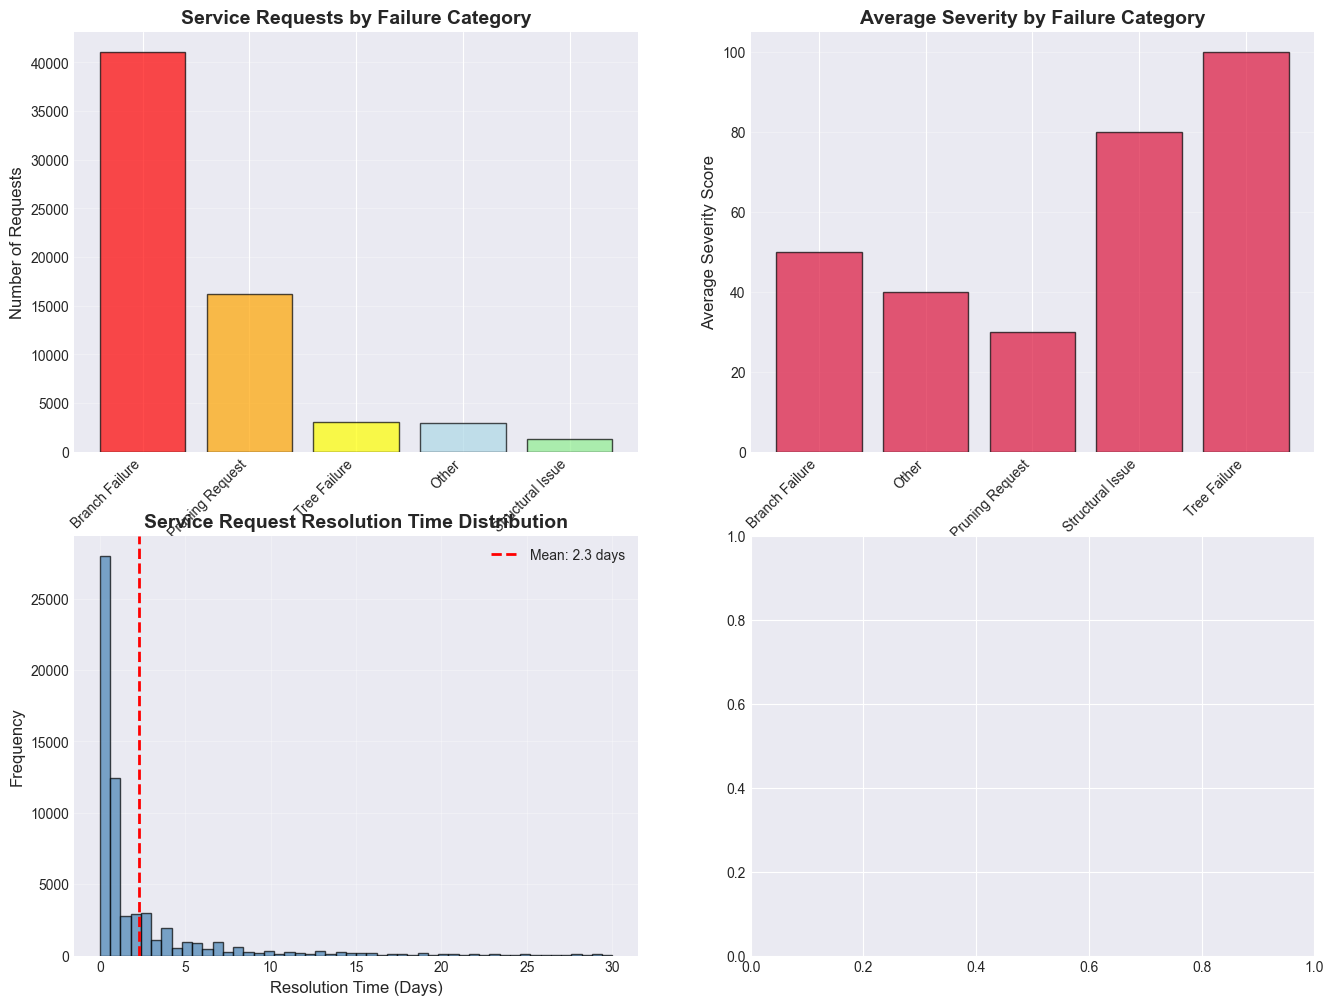

In [7]:
# Analyze failure severity based on failure type
print("=== FAILURE SEVERITY ANALYSIS ===")

# Assign severity scores
severity_map = {
    'Tree Failure': 100,  # Most severe - entire tree down
    'Structural Issue': 80,  # Major structural problems
    'Branch Failure': 50,  # Moderate - branches down
    'Pruning Request': 30,  # Preventive/maintenance
    'Other': 40  # Unknown severity
}

service_df['Severity_Score'] = service_df['Failure_Category'].map(severity_map)

# Resolution time as proxy for severity/complexity
service_df['Resolution_Time_Days'] = service_df['Resolution_Time_Hours'] / 24

# Analyze by failure category
failure_severity = service_df.groupby('Failure_Category').agg({
    'Rec#': 'count',
    'Severity_Score': 'mean',
    'Resolution_Time_Days': 'mean',
    'Resolution_Time_Hours': lambda x: x.median()
}).rename(columns={
    'Rec#': 'Count',
    'Severity_Score': 'Avg_Severity',
    'Resolution_Time_Days': 'Avg_Resolution_Days',
    'Resolution_Time_Hours': 'Median_Resolution_Hours'
})

print("\nFailure Category Analysis:")
print(failure_severity)

# Impact by property type (if we can match)
if len(merged) > 0:
    merged['Severity_Score'] = merged['Failure_Category'].map(severity_map)
    property_severity = merged.groupby('Property Type').agg({
        'Rec#': 'count',
        'Severity_Score': 'mean',
        'Failure_Category': lambda x: (x == 'Tree Failure').sum()
    }).rename(columns={
        'Rec#': 'Total_Failures',
        'Severity_Score': 'Avg_Severity',
        'Failure_Category': 'Tree_Failures'
    })
    property_severity['Tree_Failure_Rate'] = (
        property_severity['Tree_Failures'] / property_severity['Total_Failures'] * 100
    )
    
    print("\nFailure Impact by Property Type:")
    print(property_severity.sort_values('Avg_Severity', ascending=False))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Failure counts by category
failure_counts = service_df['Failure_Category'].value_counts()
axes[0, 0].bar(range(len(failure_counts)), failure_counts.values, 
               color=['red', 'orange', 'yellow', 'lightblue', 'lightgreen'], alpha=0.7, edgecolor='black')
axes[0, 0].set_xticks(range(len(failure_counts)))
axes[0, 0].set_xticklabels(failure_counts.index, rotation=45, ha='right', fontsize=10)
axes[0, 0].set_ylabel('Number of Requests', fontsize=12)
axes[0, 0].set_title('Service Requests by Failure Category', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Average severity by category
axes[0, 1].bar(range(len(failure_severity)), failure_severity['Avg_Severity'].values,
               color='crimson', alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(range(len(failure_severity)))
axes[0, 1].set_xticklabels(failure_severity.index, rotation=45, ha='right', fontsize=10)
axes[0, 1].set_ylabel('Average Severity Score', fontsize=12)
axes[0, 1].set_title('Average Severity by Failure Category', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Resolution time distribution
resolution_clean = service_df[service_df['Resolution_Time_Days'].notna() & 
                             (service_df['Resolution_Time_Days'] < 30)]['Resolution_Time_Days']
axes[1, 0].hist(resolution_clean, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(resolution_clean.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {resolution_clean.mean():.1f} days')
axes[1, 0].set_xlabel('Resolution Time (Days)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Service Request Resolution Time Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Severity vs Resolution Time
if len(merged) > 0:
    severity_resolution = merged.groupby('Failure_Category')['Resolution_Time_Days'].mean().sort_values(ascending=False)
    axes[1, 1].barh(range(len(severity_resolution)), severity_resolution.values,
                    color='forestgreen', alpha=0.7, edgecolor='black')
    axes[1, 1].set_yticks(range(len(severity_resolution)))
    axes[1, 1].set_yticklabels(severity_resolution.index, fontsize=10)
    axes[1, 1].set_xlabel('Average Resolution Time (Days)', fontsize=12)
    axes[1, 1].set_title('Resolution Time by Failure Category', fontsize=14, fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== KEY INSIGHTS ===")
print(f"Most common failure type: {failure_counts.index[0]} ({failure_counts.iloc[0]:,} requests)")
print(f"Most severe failure type: {failure_severity['Avg_Severity'].idxmax()}")
print(f"Average resolution time: {resolution_clean.mean():.1f} days")
print(f"Median resolution time: {resolution_clean.median():.1f} days")

## 5. Pruning Cycle Effectiveness Analysis

Analyzing whether current pruning schedules are effective and identifying gaps.

=== PRUNING CYCLE ANALYSIS ===

Failure Rates by Pruning Cycle Status:
                  Total_Failures  Unique_Trees  Total_Trees  Failures_per_Tree
Overdue_Status                                                                
Current                     1087           635        14029           0.077482
Due Soon                    1224           709        18136           0.067490
Overdue                     2674          1581        37186           0.071909
Severely Overdue            9162          5015       120031           0.076330
Critical                       0             0            0                NaN

=== CURRENT vs PROPOSED METHOD COMPARISON ===

Current Method (Time-Based):
  Top 1000 trees by age
  High-risk trees in top 1000: 11 (1.1%)

Proposed Method (Risk-Based):
  Top 1000 trees by risk score
  Overdue trees in top 1000: 838 (83.8%)
  Average risk score: 81.6

Failure Prevention Potential:
  Current method top 1000: 45 trees with failure history
  Proposed metho

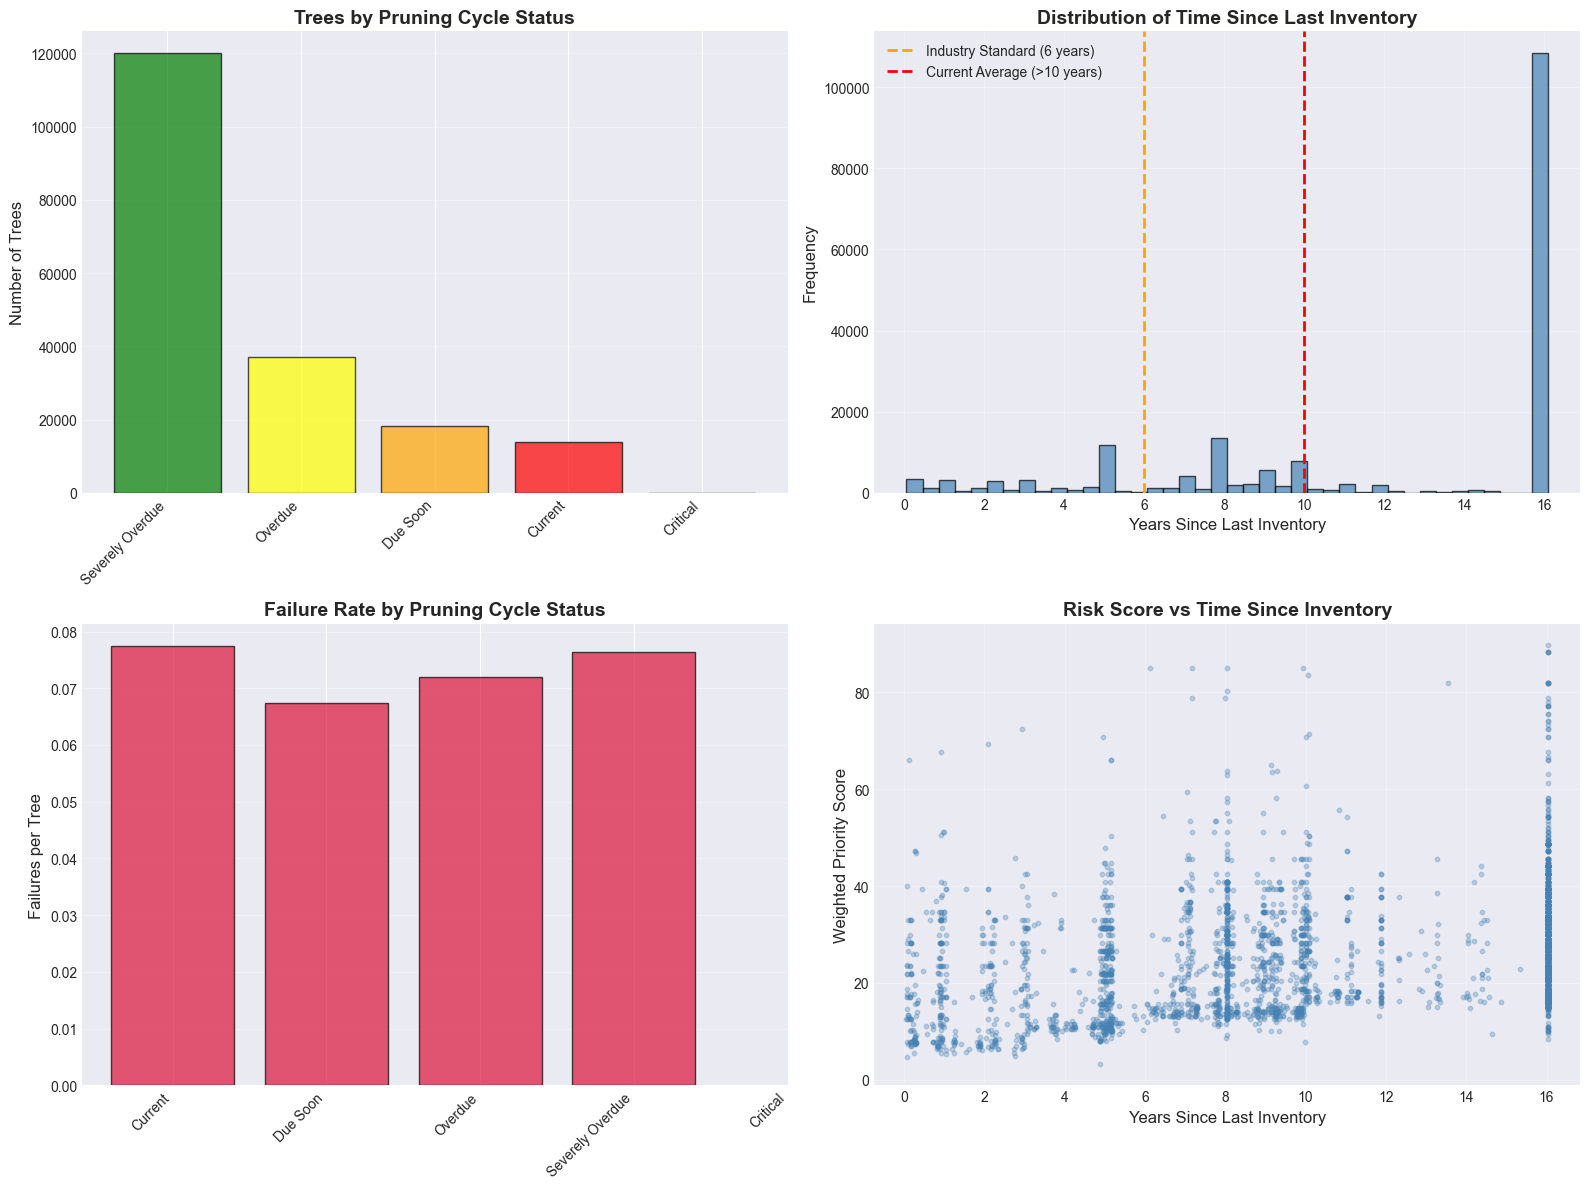


=== KEY INSIGHTS ===
Trees overdue for pruning (>6 years): 157,217 (83.0%)
Trees severely overdue (>10 years): 120,031 (63.4%)
Average years since inventory: 12.1


In [8]:
# Analyze pruning cycle effectiveness
print("=== PRUNING CYCLE ANALYSIS ===")

# Calculate time since inventory (proxy for time since last assessment/prune)
risk_df['Years_Since_Inventory'] = (current_date - risk_df['Inventory Date']).dt.days / 365.25
risk_df['Years_Since_Inventory'] = risk_df['Years_Since_Inventory'].fillna(10)

# Industry standard: 3-6 year pruning cycle
# Current situation: >10 years (per proposal)
risk_df['Overdue_Status'] = pd.cut(
    risk_df['Years_Since_Inventory'],
    bins=[0, 3, 6, 10, 20, 100],
    labels=['Current', 'Due Soon', 'Overdue', 'Severely Overdue', 'Critical']
)

# Analyze failures by pruning cycle status
if len(merged) > 0:
    merged_with_status = merged.merge(
        risk_df[['Site ID', 'Years_Since_Inventory', 'Overdue_Status']],
        on='Site ID',
        how='left'
    )
    
    pruning_effectiveness = merged_with_status.groupby('Overdue_Status').agg({
        'Rec#': 'count',
        'Site ID': 'nunique'
    }).rename(columns={
        'Rec#': 'Total_Failures',
        'Site ID': 'Unique_Trees'
    })
    
    # Calculate failure rate per tree
    status_tree_counts = risk_df.groupby('Overdue_Status').size()
    pruning_effectiveness['Total_Trees'] = status_tree_counts
    pruning_effectiveness['Failures_per_Tree'] = (
        pruning_effectiveness['Total_Failures'] / pruning_effectiveness['Total_Trees']
    )
    
    print("\nFailure Rates by Pruning Cycle Status:")
    print(pruning_effectiveness)
    
    # Compare current method (time-based) vs proposed method (risk-based)
    print("\n=== CURRENT vs PROPOSED METHOD COMPARISON ===")
    
    # Current method: prioritize by time since last prune (oldest first)
    current_method_priority = risk_df.nlargest(1000, 'Years_Since_Inventory')
    current_method_high_risk = current_method_priority[
        current_method_priority['Weighted_Priority_Score'] > 70
    ]
    
    # Proposed method: prioritize by risk score
    proposed_method_priority = risk_df.nlargest(1000, 'Weighted_Priority_Score')
    proposed_method_overdue = proposed_method_priority[
        proposed_method_priority['Years_Since_Inventory'] > 10
    ]
    
    print(f"\nCurrent Method (Time-Based):")
    print(f"  Top 1000 trees by age")
    print(f"  High-risk trees in top 1000: {len(current_method_high_risk)} ({len(current_method_high_risk)/1000*100:.1f}%)")
    
    print(f"\nProposed Method (Risk-Based):")
    print(f"  Top 1000 trees by risk score")
    print(f"  Overdue trees in top 1000: {len(proposed_method_overdue)} ({len(proposed_method_overdue)/1000*100:.1f}%)")
    print(f"  Average risk score: {proposed_method_priority['Weighted_Priority_Score'].head(1000).mean():.1f}")
    
    # Calculate potential impact
    if len(merged) > 0:
        current_method_failures = current_method_priority['Site ID'].isin(merged['Site ID']).sum()
        proposed_method_failures = proposed_method_priority['Site ID'].isin(merged['Site ID']).sum()
        
        print(f"\nFailure Prevention Potential:")
        print(f"  Current method top 1000: {current_method_failures} trees with failure history")
        print(f"  Proposed method top 1000: {proposed_method_failures} trees with failure history")
        print(f"  Improvement: {((proposed_method_failures - current_method_failures) / current_method_failures * 100):.1f}% more failure-prone trees identified")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Pruning cycle status distribution
status_counts = risk_df['Overdue_Status'].value_counts()
axes[0, 0].bar(range(len(status_counts)), status_counts.values,
               color=['green', 'yellow', 'orange', 'red', 'darkred'], alpha=0.7, edgecolor='black')
axes[0, 0].set_xticks(range(len(status_counts)))
axes[0, 0].set_xticklabels(status_counts.index, rotation=45, ha='right', fontsize=10)
axes[0, 0].set_ylabel('Number of Trees', fontsize=12)
axes[0, 0].set_title('Trees by Pruning Cycle Status', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Years since inventory distribution
years_clean = risk_df[risk_df['Years_Since_Inventory'] < 20]['Years_Since_Inventory']
axes[0, 1].hist(years_clean, bins=40, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(6, color='orange', linestyle='--', linewidth=2, label='Industry Standard (6 years)')
axes[0, 1].axvline(10, color='red', linestyle='--', linewidth=2, label='Current Average (>10 years)')
axes[0, 1].set_xlabel('Years Since Last Inventory', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of Time Since Last Inventory', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Failure rate by pruning status
if len(merged) > 0 and 'pruning_effectiveness' in locals():
    axes[1, 0].bar(range(len(pruning_effectiveness)), pruning_effectiveness['Failures_per_Tree'].values,
                   color='crimson', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xticks(range(len(pruning_effectiveness)))
    axes[1, 0].set_xticklabels(pruning_effectiveness.index, rotation=45, ha='right', fontsize=10)
    axes[1, 0].set_ylabel('Failures per Tree', fontsize=12)
    axes[1, 0].set_title('Failure Rate by Pruning Cycle Status', fontsize=14, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)

# Risk score vs years since inventory
sample_size = min(5000, len(risk_df))
sample_df = risk_df.sample(n=sample_size, random_state=42)
axes[1, 1].scatter(sample_df['Years_Since_Inventory'], sample_df['Weighted_Priority_Score'],
                  alpha=0.3, s=10, color='steelblue')
axes[1, 1].set_xlabel('Years Since Last Inventory', fontsize=12)
axes[1, 1].set_ylabel('Weighted Priority Score', fontsize=12)
axes[1, 1].set_title('Risk Score vs Time Since Inventory', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== KEY INSIGHTS ===")
print(f"Trees overdue for pruning (>6 years): {(risk_df['Years_Since_Inventory'] > 6).sum():,} ({(risk_df['Years_Since_Inventory'] > 6).sum() / len(risk_df) * 100:.1f}%)")
print(f"Trees severely overdue (>10 years): {(risk_df['Years_Since_Inventory'] > 10).sum():,} ({(risk_df['Years_Since_Inventory'] > 10).sum() / len(risk_df) * 100:.1f}%)")
print(f"Average years since inventory: {risk_df['Years_Since_Inventory'].mean():.1f}")

## 6. Quarter Section Aggregation for Management Tool

Per the project proposal, we need to aggregate individual tree scores into Quarter Section heat maps for annual operational planning.

=== QUARTER SECTION AGGREGATION FOR MANAGEMENT TOOL ===

Top 30 Priority Quarter Sections for Pruning:
                 Total_Trees  Avg_Risk_Score  High_Risk_Trees  Critical_Trees  \
Quarter Section                                                                 
122                      317           36.71               17              17   
137                      229           36.45               13              13   
156                      119           35.05                0               0   
183                       96           33.98                2               2   
148                      313           33.23               10              10   
539                      678           33.12               28              28   
578                      264           32.93               24              24   
457                      412           32.85               20              20   
150                      248           32.49                5               5   
143   

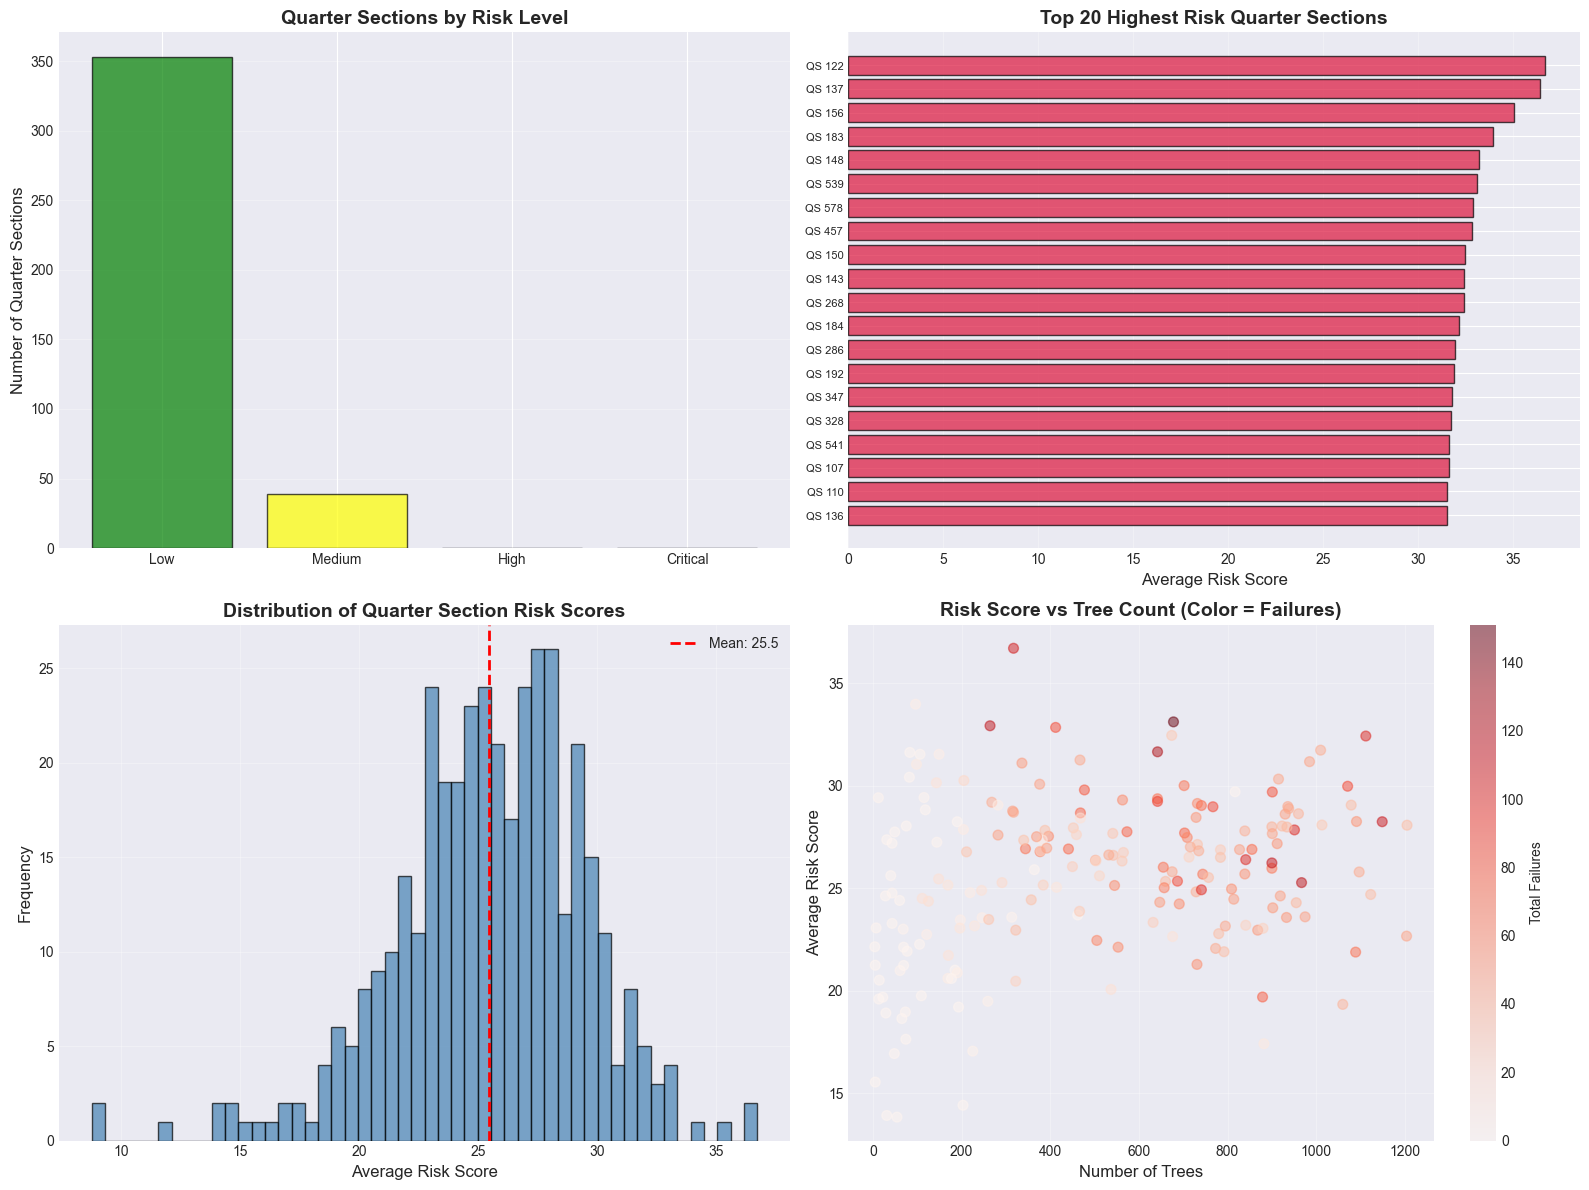


Exported Quarter Section priorities to: quarter_section_priorities.csv


In [9]:
# Aggregate risk scores by Quarter Section for management dashboard
print("=== QUARTER SECTION AGGREGATION FOR MANAGEMENT TOOL ===")

qs_aggregated = risk_df.groupby('Quarter Section').agg({
    'Site ID': 'count',
    'Weighted_Priority_Score': ['mean', 'max', lambda x: (x > 70).sum()],
    'Risk_Category': lambda x: (x == 'Critical').sum(),
    'Failure_History': 'sum',
    'DBH': 'mean',
    'Condition': lambda x: (x == 'Poor').sum()
}).round(2)

# Flatten column names
qs_aggregated.columns = [
    'Total_Trees',
    'Avg_Risk_Score',
    'Max_Risk_Score',
    'High_Risk_Trees',
    'Critical_Trees',
    'Total_Failures',
    'Avg_DBH',
    'Poor_Condition_Trees'
]

# Calculate priority rank
qs_aggregated['Priority_Rank'] = qs_aggregated['Avg_Risk_Score'].rank(ascending=False, method='min').astype(int)

# Risk level categorization for heat map
qs_aggregated['Risk_Level'] = pd.cut(
    qs_aggregated['Avg_Risk_Score'],
    bins=[0, 30, 50, 70, 100],
    labels=['Low', 'Medium', 'High', 'Critical']
)

# Sort by priority
qs_aggregated = qs_aggregated.sort_values('Priority_Rank')

print(f"\nTop 30 Priority Quarter Sections for Pruning:")
print(qs_aggregated.head(30)[['Total_Trees', 'Avg_Risk_Score', 'High_Risk_Trees', 
                               'Critical_Trees', 'Total_Failures', 'Priority_Rank', 'Risk_Level']])

# Summary statistics
print(f"\n=== QUARTER SECTION SUMMARY ===")
print(f"Total Quarter Sections: {len(qs_aggregated):,}")
print(f"Critical Risk QS: {(qs_aggregated['Risk_Level'] == 'Critical').sum():,}")
print(f"High Risk QS: {(qs_aggregated['Risk_Level'] == 'High').sum():,}")
print(f"Medium Risk QS: {(qs_aggregated['Risk_Level'] == 'Medium').sum():,}")
print(f"Low Risk QS: {(qs_aggregated['Risk_Level'] == 'Low').sum():,}")

# Resource allocation estimate
# Assume we can prune 1000 trees per year (adjust based on actual capacity)
annual_capacity = 1000
critical_qs_trees = qs_aggregated[qs_aggregated['Risk_Level'] == 'Critical']['Total_Trees'].sum()
high_qs_trees = qs_aggregated[qs_aggregated['Risk_Level'] == 'High']['Total_Trees'].sum()

print(f"\n=== RESOURCE ALLOCATION ESTIMATE ===")
print(f"Annual pruning capacity (assumed): {annual_capacity:,} trees")
print(f"Critical QS total trees: {critical_qs_trees:,.0f}")
print(f"High QS total trees: {high_qs_trees:,.0f}")
print(f"Years to address critical QS: {critical_qs_trees / annual_capacity:.1f}")
print(f"Years to address high + critical QS: {(critical_qs_trees + high_qs_trees) / annual_capacity:.1f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Risk level distribution
risk_level_counts = qs_aggregated['Risk_Level'].value_counts()
colors_map = {'Low': 'green', 'Medium': 'yellow', 'High': 'orange', 'Critical': 'red'}
colors = [colors_map.get(level, 'gray') for level in risk_level_counts.index]
axes[0, 0].bar(range(len(risk_level_counts)), risk_level_counts.values, color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_xticks(range(len(risk_level_counts)))
axes[0, 0].set_xticklabels(risk_level_counts.index)
axes[0, 0].set_ylabel('Number of Quarter Sections', fontsize=12)
axes[0, 0].set_title('Quarter Sections by Risk Level', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Top 20 Quarter Sections by Risk Score
top_20_qs = qs_aggregated.head(20)
axes[0, 1].barh(range(len(top_20_qs)), top_20_qs['Avg_Risk_Score'].values,
                color='crimson', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(top_20_qs)))
axes[0, 1].set_yticklabels([f"QS {idx}" for idx in top_20_qs.index[:20]], fontsize=8)
axes[0, 1].set_xlabel('Average Risk Score', fontsize=12)
axes[0, 1].set_title('Top 20 Highest Risk Quarter Sections', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].invert_yaxis()

# Risk Score Distribution
axes[1, 0].hist(qs_aggregated['Avg_Risk_Score'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(qs_aggregated['Avg_Risk_Score'].mean(), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {qs_aggregated["Avg_Risk_Score"].mean():.1f}')
axes[1, 0].set_xlabel('Average Risk Score', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Distribution of Quarter Section Risk Scores', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Trees per Quarter Section vs Risk Score
sample_qs = qs_aggregated.sample(n=min(200, len(qs_aggregated)), random_state=42)
axes[1, 1].scatter(sample_qs['Total_Trees'], sample_qs['Avg_Risk_Score'],
                  alpha=0.5, s=50, c=sample_qs['Total_Failures'], cmap='Reds')
axes[1, 1].set_xlabel('Number of Trees', fontsize=12)
axes[1, 1].set_ylabel('Average Risk Score', fontsize=12)
axes[1, 1].set_title('Risk Score vs Tree Count (Color = Failures)', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Total Failures', fontsize=10)

plt.tight_layout()
plt.show()

# Export for dashboard
qs_export = qs_aggregated.reset_index()
qs_export.to_csv('../../data/quarter_section_priorities.csv', index=False)
print(f"\nExported Quarter Section priorities to: quarter_section_priorities.csv")

## 7. Summary and Recommendations

### Key Findings for Project Proposal

In [10]:
# Final summary and recommendations
print("=" * 80)
print("FURTHER ANALYSIS SUMMARY")
print("=" * 80)

# Get temporal insights (from cell 3)
try:
    monthly_counts = service_df.groupby('Month')['Rec#'].count()
    seasonal_counts = service_df.groupby('Season')['Rec#'].count()
    yearly_counts = service_df.groupby('Year')['Rec#'].count()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    peak_month = monthly_counts.idxmax()
    peak_season = seasonal_counts.idxmax()
    
    print("\n1. TEMPORAL PATTERNS:")
    print(f"   - Peak failure season: {peak_season}")
    print(f"   - Peak failure month: {month_names[peak_month-1]}")
    if len(yearly_counts) > 1:
        trend = 'Increasing' if yearly_counts.iloc[-1] > yearly_counts.iloc[0] else 'Decreasing'
        print(f"   - Yearly trend: {trend}")
except Exception as e:
    print("\n1. TEMPORAL PATTERNS: (Run temporal analysis cell first)")

# Geographic insights (from cell 5)
try:
    print("\n2. GEOGRAPHIC RISK:")
    print(f"   - Highest risk district: {district_analysis['Failure_Rate'].idxmax()}")
    print(f"   - Quarter sections requiring attention: {(qs_aggregated['Risk_Level'].isin(['High', 'Critical'])).sum():,}")
except:
    print("\n2. GEOGRAPHIC RISK: (Run geographic analysis cell first)")

# Risk scoring insights (from cell 7)
try:
    print("\n3. RISK SCORING:")
    print(f"   - Trees in Critical risk category: {(risk_df['Risk_Category'] == 'Critical').sum():,}")
    print(f"   - Trees in High risk category: {(risk_df['Risk_Category'] == 'High').sum():,}")
    print(f"   - Average weighted priority score: {risk_df['Weighted_Priority_Score'].mean():.1f}")
except:
    print("\n3. RISK SCORING: (Run risk scoring cell first)")

# Pruning cycle insights (from cell 11)
try:
    print("\n4. PRUNING CYCLE:")
    print(f"   - Trees overdue (>6 years): {(risk_df['Years_Since_Inventory'] > 6).sum():,}")
    print(f"   - Trees severely overdue (>10 years): {(risk_df['Years_Since_Inventory'] > 10).sum():,}")
    print(f"   - Current average cycle: {risk_df['Years_Since_Inventory'].mean():.1f} years")
except:
    print("\n4. PRUNING CYCLE: (Run pruning cycle analysis cell first)")

# Failure severity insights (from cell 9)
try:
    failure_counts = service_df['Failure_Category'].value_counts()
    failure_severity = service_df.groupby('Failure_Category').agg({
        'Severity_Score': 'mean'
    })
    resolution_clean = service_df[service_df['Resolution_Time_Days'].notna() & 
                                 (service_df['Resolution_Time_Days'] < 30)]['Resolution_Time_Days']
    
    print("\n5. FAILURE SEVERITY:")
    print(f"   - Most common failure: {failure_counts.index[0]}")
    print(f"   - Most severe failure: {failure_severity['Severity_Score'].idxmax()}")
    print(f"   - Average resolution time: {resolution_clean.mean():.1f} days")
except:
    print("\n5. FAILURE SEVERITY: (Run failure severity cell first)")

# Quarter section insights (from cell 13)
try:
    annual_capacity = 1000
    critical_qs_trees = qs_aggregated[qs_aggregated['Risk_Level'] == 'Critical']['Total_Trees'].sum()
    
    print("\n6. QUARTER SECTION PRIORITIES:")
    print(f"   - Critical QS: {(qs_aggregated['Risk_Level'] == 'Critical').sum():,}")
    print(f"   - High QS: {(qs_aggregated['Risk_Level'] == 'High').sum():,}")
    print(f"   - Estimated years to address critical QS: {critical_qs_trees / annual_capacity:.1f}")
except:
    print("\n6. QUARTER SECTION PRIORITIES: (Run quarter section aggregation cell first)")

print("\n" + "=" * 80)
print("RECOMMENDATIONS FOR MODEL DEVELOPMENT:")
print("=" * 80)
print("""
1. WEIGHTED PRIORITY SCORE ALGORITHM:
   - Use multi-factor scoring: Species (20%), Condition (20%), Failure History (25%), 
     DBH (15%), Property Type (10%), Pruning Cycle (10%)
   - Normalize scores to 0-100 scale for easy interpretation

2. QUARTER SECTION AGGREGATION:
   - Aggregate individual tree scores by Quarter Section
   - Create heat map visualization for management dashboard
   - Prioritize Quarter Sections with highest average risk scores

3. CURRENT vs PROPOSED METHOD COMPARISON:
   - Current method (time-based) misses high-risk trees
   - Proposed method (risk-based) better identifies failure-prone trees
   - Use this comparison for budget justification

4. RESOURCE ALLOCATION:
   - Focus on Critical and High risk Quarter Sections first
   - Consider seasonal patterns for staffing
   - Prioritize high-impact property types (schools, hospitals, high-traffic areas)

5. TEMPORAL CONSIDERATIONS:
   - Plan for peak failure seasons
   - Account for weather-related patterns
   - Monitor yearly trends for budget planning

6. DATA GAPS TO ADDRESS:
   - Improve matching rate between service requests and inventory
   - Collect more detailed failure severity data
   - Track actual pruning dates (not just inventory dates)
   - Consider environmental factors (soil, weather, proximity to utilities)
""")

# Export final risk-scored dataset
try:
    risk_export = risk_df[[
        'Site ID', 'Quarter Section', 'Address', 'Street', 'Species', 'Species_Simple',
        'DBH', 'Condition', 'Property Type', 'District', 'Latitude', 'Longitude',
        'Species_Risk', 'DBH_Risk', 'Condition_Risk', 'Failure_Risk', 'Property_Risk',
        'Pruning_Cycle_Risk', 'Weighted_Priority_Score', 'Risk_Category',
        'Failure_History', 'Years_Since_Inventory', 'Estimated_Age'
    ]]
    
    risk_export.to_csv('../../data/advanced_risk_scores.csv', index=False)
    print(f"\nExported advanced risk scores to: advanced_risk_scores.csv")
    print(f"Total trees with risk scores: {len(risk_export):,}")
except Exception as e:
    print(f"\nNote: Could not export risk scores. Make sure all previous cells have been executed.")
    print(f"Error: {e}")

FURTHER ANALYSIS SUMMARY

1. TEMPORAL PATTERNS:
   - Peak failure season: Summer
   - Peak failure month: Aug
   - Yearly trend: Decreasing

2. GEOGRAPHIC RISK:
   - Highest risk district: South
   - Quarter sections requiring attention: 0

3. RISK SCORING:
   - Trees in Critical risk category: 1,616
   - Trees in High risk category: 2,478
   - Average weighted priority score: 26.2

4. PRUNING CYCLE:
   - Trees overdue (>6 years): 157,217
   - Trees severely overdue (>10 years): 120,031
   - Current average cycle: 12.1 years

5. FAILURE SEVERITY:
   - Most common failure: Branch Failure
   - Most severe failure: Tree Failure
   - Average resolution time: 2.3 days

6. QUARTER SECTION PRIORITIES:
   - Critical QS: 0
   - High QS: 0
   - Estimated years to address critical QS: 0.0

RECOMMENDATIONS FOR MODEL DEVELOPMENT:

1. WEIGHTED PRIORITY SCORE ALGORITHM:
   - Use multi-factor scoring: Species (20%), Condition (20%), Failure History (25%), 
     DBH (15%), Property Type (10%), Pruning 